# Mesh examples

this notebook illustrates the basic ways of interacting with the pyro2 mesh module.  We create some data that lives on a grid and show how to fill the ghost cells.  The pretty_print() function shows us that they work as expected.

In [1]:
import numpy as np
import pyro.mesh.boundary as bnd
import pyro.mesh.patch as patch
import matplotlib.pyplot as plt
%matplotlib inline

# for unit testing, we want to ensure the same random numbers
np.random.seed(100)

## Setup a Grid with Variables

There are a few core classes that we deal with when creating a grid with associated variables:

* `Grid2d` : this holds the size of the grid (in zones) and the physical coordinate information, including coordinates of cell edges and centers

* `BC` : this is a container class that simply holds the type of boundary condition on each domain edge.

* `ArrayIndexer` : this is an array of data along with methods that know how to access it with different offsets into the data that usually arise in stencils (like {i+1, j})

* `CellCenterData2d` : this holds the data that lives on a grid.  Each variable that is part of this class has its own boundary condition type.

We start by creating a `Grid2d` object with 4 x 6 cells and 2 ghost cells

In [2]:
g = patch.Grid2d(4, 6, ng=2)
print(g)

2-d grid: nx = 4, ny = 6, ng = 2


In [3]:
help(g)

Help on Grid2d in module pyro.mesh.patch object:

class Grid2d(builtins.object)
 |  Grid2d(nx, ny, ng=1, xmin=0.0, xmax=1.0, ymin=0.0, ymax=1.0)
 |  
 |  the 2-d grid class.  The grid object will contain the coordinate
 |  information (at various centerings).
 |  
 |  A basic (1-d) representation of the layout is::
 |  
 |     |     |      |     X     |     |      |     |     X     |      |     |
 |     +--*--+- // -+--*--X--*--+--*--+- // -+--*--+--*--X--*--+- // -+--*--+
 |        0          ng-1    ng   ng+1         ... ng+nx-1 ng+nx      2ng+nx-1
 |  
 |                          ilo                      ihi
 |  
 |     |<- ng guardcells->|<---- nx interior zones ----->|<- ng guardcells->|
 |  
 |  The '*' marks the data locations.
 |  
 |  Methods defined here:
 |  
 |  __eq__(self, other)
 |      are two grids equivalent?
 |  
 |  __init__(self, nx, ny, ng=1, xmin=0.0, xmax=1.0, ymin=0.0, ymax=1.0)
 |      Create a Grid2d object.
 |      
 |      The only data that we require is t

Then create a dataset that lives on this grid and add a variable name.  For each variable that lives on the grid, we need to define the boundary conditions -- this is done through the BC object.

In [4]:
bc = bnd.BC(xlb="periodic", xrb="periodic", ylb="reflect", yrb="outflow")
print(bc)

BCs: -x: periodic  +x: periodic  -y: reflect-even  +y: outflow


In [5]:
d = patch.CellCenterData2d(g)
d.register_var("a", bc)
d.create()
print(d)

cc data: nx = 4, ny = 6, ng = 2
         nvars = 1
         variables:
               a: min:    0.0000000000    max:    0.0000000000
                  BCs: -x: periodic     +x: periodic     -y: reflect-even +y: outflow     



## Working with the data

Now we fill the grid with random data.  `get_var()` returns an `ArrayIndexer` object that has methods for accessing views into the data.  Here we use `a.v()` to get the "valid" region, i.e. excluding ghost cells.

In [6]:
a = d.get_var("a")
a.v()[:,:] = np.random.rand(g.nx, g.ny)

when we pretty_print() the variable, we see the ghost cells colored red.  Note that we just filled the interior above.

In [7]:
a.pretty_print()

         0         0         0         0         0         0         0         0 
         0         0         0         0         0         0         0         0 
         0         0   0.12157    0.2092   0.17194   0.33611         0         0 
         0         0 0.0047189   0.89132   0.81168   0.81765         0         0 
         0         0   0.84478   0.57509   0.97862   0.94003         0         0 
         0         0   0.42452   0.13671    0.2197    0.4317         0         0 
         0         0   0.27837   0.82585   0.10838   0.27407         0         0 
         0         0    0.5434   0.67075   0.18533   0.81622         0         0 
         0         0         0         0         0         0         0         0 
         0         0         0         0         0         0         0         0 

         ^ y
         |
         +---> x
        


`pretty_print()` can also take an argument, specifying the format string to be used for the output.

In [8]:
a.pretty_print(fmt="%7.3g")

      0      0      0      0      0      0      0      0 
      0      0      0      0      0      0      0      0 
      0      0  0.122  0.209  0.172  0.336      0      0 
      0      00.00472  0.891  0.812  0.818      0      0 
      0      0  0.845  0.575  0.979   0.94      0      0 
      0      0  0.425  0.137   0.22  0.432      0      0 
      0      0  0.278  0.826  0.108  0.274      0      0 
      0      0  0.543  0.671  0.185  0.816      0      0 
      0      0      0      0      0      0      0      0 
      0      0      0      0      0      0      0      0 

         ^ y
         |
         +---> x
        


now fill the ghost cells -- notice that the left and right are periodic, the upper is outflow, and the lower is reflect, as specified when we registered the data above.

In [9]:
d.fill_BC("a")
a.pretty_print()

   0.17194   0.33611   0.12157    0.2092   0.17194   0.33611   0.12157    0.2092 
   0.17194   0.33611   0.12157    0.2092   0.17194   0.33611   0.12157    0.2092 
   0.17194   0.33611   0.12157    0.2092   0.17194   0.33611   0.12157    0.2092 
   0.81168   0.81765 0.0047189   0.89132   0.81168   0.81765 0.0047189   0.89132 
   0.97862   0.94003   0.84478   0.57509   0.97862   0.94003   0.84478   0.57509 
    0.2197    0.4317   0.42452   0.13671    0.2197    0.4317   0.42452   0.13671 
   0.10838   0.27407   0.27837   0.82585   0.10838   0.27407   0.27837   0.82585 
   0.18533   0.81622    0.5434   0.67075   0.18533   0.81622    0.5434   0.67075 
   0.18533   0.81622    0.5434   0.67075   0.18533   0.81622    0.5434   0.67075 
   0.10838   0.27407   0.27837   0.82585   0.10838   0.27407   0.27837   0.82585 

         ^ y
         |
         +---> x
        


We can find the L2 norm of the data easily

In [10]:
a.norm()

0.5749769043407793

and the min and max

In [11]:
print(a.min(), a.max())

0.004718856190972565 0.9786237847073697


## `ArrayIndexer`

We we access the data, an `ArrayIndexer` object is returned.  The `ArrayIndexer` sub-classes the NumPy `ndarray`, so it can do all of the methods that a NumPy array can, but in addition, we can use the `ip()`, `jp()`, or `ip_jp()` methods to the `ArrayIndexer` object shift our view in the x, y, or x & y directions.

To make this clearer, we'll change our data set to be nicely ordered numbers.  We index the `ArrayIndex` the same way we would a NumPy array.  The index space includes ghost cells, so the `ilo` and `ihi` attributes from the grid object are useful to index just the valid region.  The `.v()` method is a shortcut that also gives a view into just the valid data.

Note: when we use one of the `ip()`, `jp()`, `ip_jp()`, or `v()` methods, the result is a regular NumPy `ndarray`, not an `ArrayIndexer` object.  This is because it only spans part of the domain (e.g., no ghost cells), and therefore cannot be associated with the `Grid2d` object that the `ArrayIndexer` is built from.

In [12]:
type(a)

pyro.mesh.array_indexer.ArrayIndexer

In [13]:
type(a.v())

numpy.ndarray

In [14]:
a[:,:] = np.arange(g.qx*g.qy).reshape(g.qx, g.qy)

In [15]:
a.pretty_print()

         9        19        29        39        49        59        69        79 
         8        18        28        38        48        58        68        78 
         7        17        27        37        47        57        67        77 
         6        16        26        36        46        56        66        76 
         5        15        25        35        45        55        65        75 
         4        14        24        34        44        54        64        74 
         3        13        23        33        43        53        63        73 
         2        12        22        32        42        52        62        72 
         1        11        21        31        41        51        61        71 
         0        10        20        30        40        50        60        70 

         ^ y
         |
         +---> x
        


We index our arrays as {i,j}, so x (indexed by i) is the row and y (indexed by j) is the column in the NumPy array.   Note that python arrays are stored in row-major order, which means that all of the entries in the same row are adjacent in memory.  This means that when we simply print out the `ndarray`, we see constant-x horizontally, which is the transpose of what we are used to.

In [16]:
a.v()

array([[22., 23., 24., 25., 26., 27.],
       [32., 33., 34., 35., 36., 37.],
       [42., 43., 44., 45., 46., 47.],
       [52., 53., 54., 55., 56., 57.]])

We can offset our view into the array by one in x -- this would be like {i+1, j} when we loop over data.  The `ip()` method is used here, and takes an argument which is the (positive) shift in the x (i) direction.  So here's a shift by 1

In [17]:
a.ip(-1, buf=1)

array([[ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.],
       [11., 12., 13., 14., 15., 16., 17., 18.],
       [21., 22., 23., 24., 25., 26., 27., 28.],
       [31., 32., 33., 34., 35., 36., 37., 38.],
       [41., 42., 43., 44., 45., 46., 47., 48.],
       [51., 52., 53., 54., 55., 56., 57., 58.]])

A shifted view is necessarily smaller than the original array, and relies on ghost cells to bring new data into view.  Because of this, the underlying data is no longer the same size as the original data, so we return it as an `ndarray` (which is actually just a view into the data in the `ArrayIndexer` object, so no copy is made.

To see that it is simply a view, lets shift and edit the data

In [18]:
d = a.ip(1)
d[1,1] = 0.0
a.pretty_print()

         9        19        29        39        49        59        69        79 
         8        18        28        38        48        58        68        78 
         7        17        27        37        47        57        67        77 
         6        16        26        36        46        56        66        76 
         5        15        25        35        45        55        65        75 
         4        14        24        34        44        54        64        74 
         3        13        23        33         0        53        63        73 
         2        12        22        32        42        52        62        72 
         1        11        21        31        41        51        61        71 
         0        10        20        30        40        50        60        70 

         ^ y
         |
         +---> x
        


Here, since d was really a view into $a_{i+1,j}$, and we accessed element (1,1) into that view (with 0,0 as the origin), we were really accessing the element (2,1) in the valid region

## Differencing

`ArrayIndexer` objects are easy to use to construct differences, like those that appear in a stencil for a finite-difference, without having to explicitly loop over the elements of the array.

Here's we'll create a new dataset that is initialized with a sine function

In [19]:
g = patch.Grid2d(8, 8, ng=2)
d = patch.CellCenterData2d(g)
bc = bnd.BC(xlb="periodic", xrb="periodic", ylb="periodic", yrb="periodic")
d.register_var("a", bc)
d.create()

a = d.get_var("a")
a[:,:] = np.sin(2.0*np.pi*a.g.x2d)
d.fill_BC("a")

Our grid object can provide us with a scratch array (an `ArrayIndexer` object) define on the same grid

In [20]:
b = g.scratch_array()
type(b)

pyro.mesh.array_indexer.ArrayIndexer

We can then fill the data in this array with differenced data from our original array -- since `b` has a separate data region in memory, its elements are independent of `a`.  We do need to make sure that we have the same number of elements on the left and right of the `=`.  Since by default, `ip()` will return a view with the same size as the valid region, we can use `.v()` on the left to accept the differences.

Here we compute a centered-difference approximation to the first derivative

In [21]:
b.v()[:,:] = (a.ip(1) - a.ip(-1))/(2.0*a.g.dx)
# normalization was 2.0*pi
b[:,:] /= 2.0*np.pi

0.125


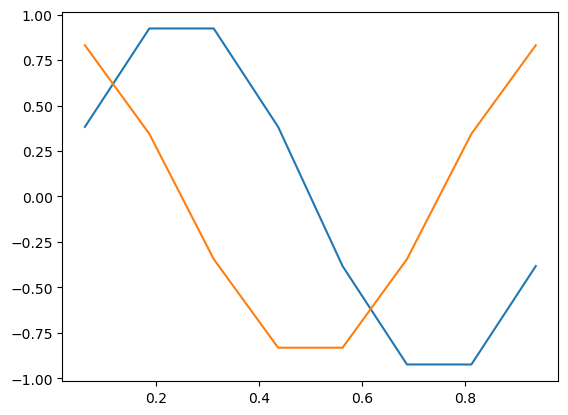

In [22]:
plt.plot(g.x[g.ilo:g.ihi+1], a[g.ilo:g.ihi+1,a.g.jc])
plt.plot(g.x[g.ilo:g.ihi+1], b[g.ilo:g.ihi+1,b.g.jc])
print (a.g.dx)

## Coarsening and prolonging

we can get a new `ArrayIndexer` object on a coarser grid for one of our variables

In [23]:
c = d.restrict("a")

In [24]:
c.pretty_print()

         0         0         0         0         0         0         0         0 
         0         0         0         0         0         0         0         0 
         0         0   0.65328   0.65328  -0.65328  -0.65328         0         0 
         0         0   0.65328   0.65328  -0.65328  -0.65328         0         0 
         0         0   0.65328   0.65328  -0.65328  -0.65328         0         0 
         0         0   0.65328   0.65328  -0.65328  -0.65328         0         0 
         0         0         0         0         0         0         0         0 
         0         0         0         0         0         0         0         0 

         ^ y
         |
         +---> x
        


or a finer grid

In [25]:
f = d.prolong("a")

In [26]:
f.pretty_print(fmt="%6.2g")

     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0 
     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0 
     0     0  0.22  0.55  0.86  0.99  0.99  0.86  0.55  0.22 -0.22 -0.55 -0.86 -0.99 -0.99 -0.86 -0.55 -0.22     0     0 
     0     0  0.22  0.55  0.86  0.99  0.99  0.86  0.55  0.22 -0.22 -0.55 -0.86 -0.99 -0.99 -0.86 -0.55 -0.22     0     0 
     0     0  0.22  0.55  0.86  0.99  0.99  0.86  0.55  0.22 -0.22 -0.55 -0.86 -0.99 -0.99 -0.86 -0.55 -0.22     0     0 
     0     0  0.22  0.55  0.86  0.99  0.99  0.86  0.55  0.22 -0.22 -0.55 -0.86 -0.99 -0.99 -0.86 -0.55 -0.22     0     0 
     0     0  0.22  0.55  0.86  0.99  0.99  0.86  0.55  0.22 -0.22 -0.55 -0.86 -0.99 -0.99 -0.86 -0.55 -0.22     0     0 
     0     0  0.22  0.55  0.86  0.99  0.99  0.86  0.55  0.22 -0.22 -0.55 -0.86 -0.99 -0.99 -0.86 -0.55 -0.22     0     0 
     0     0  0.22  0.55